# Bandpass Filtering In Audio Front End (AFE) Of Xylo™Audio 3

 The key feature extraction module in Xylo™Audio 3 is the collectuion of Mel-filterbanks, which compute the time-frequency transform of the input audio signal. In this tutorial we will review main features of the filterbank and provide instructions to reconfigure them if needed. 

Central frequency and all parameters of the filterbank have been designed for efficient audio processing, convering the range of $100~Hz$ up to around $17~KHz$ audio spectrum. 
  Main features of the filterbank include:

 * Logarithmically spaced, matched to human perception mechanism, with following **frequency scaling** $\alpha$ and **quality factor** $Q$:

     $ \alpha = (\frac{17000}{100})^{1/(16-1)}= 170^{\frac{1}{15}} = 1.4083$    and $~~~~~~ Q \approx 6$ 
     
 *  Designed as order-1 Butterworth filters  with digital transfer function: $~~~~~~\Large H(z)= \frac{b(z)}{a(z)}=\frac{b_0 + b_1 z + b_2 z^2}{a_0 + a_1 z + a_2 z^2}$.
 
 *   Implemented as a cascaded of AR (auto-regressive filter) $H_1(z)=\frac{1}{a(z)}$ followed by the MA (moving average) filter $H_2(z)=b(z)$, as illustrated in Figure 1.

 *   **In Rockpool:**  implemented as quantized digital filterbank with hard coded parameters. (See :py:class:`~.syns65302.AFESim`). 


Default central frequencies in Xylo™Audio 3 are:

In [1]:
import numpy as np
f0 = 100
f15 = 17000
N_filters = 16 # number of filters
alpha = np.power(f15/f0, 1/(N_filters-1))
freqs = [f0]
for i in range(1,N_filters):
    freqs.append(int(alpha*freqs[-1]))
print(f'designed filter centers are: {freqs}')    

designed filter centers are: [100, 140, 197, 277, 390, 549, 773, 1088, 1532, 2157, 3037, 4277, 6023, 8482, 11945, 16822]


After parameter quantization there will be a shift in central frequency of filters. Therefore true values for centers of filters in :py:class:`~.syns65302.AFESim` and HDK are: 

$ [105, 136, 201, 279, 390, 542, 762, 1070, 1503, 2110, 2963, 4161, 5843, 8204, 11582, 16611] $

Let's instantiate AFESim:

In [2]:
from rockpool.devices.xylo.syns65302 import AFESimExternal
import warnings
warnings.filterwarnings('ignore')

dt_s = 0.009994
afesim_external = AFESimExternal.from_specification(spike_gen_mode="divisive_norm",
                                                    fixed_threshold_vec = None,
                                                    rate_scale_factor=63,
                                                    low_pass_averaging_window=84e-3,
                                                    dn_EPS=32,
                                                    dt=dt_s,)

Let's demonstrate the response of filters in the simulator :py:class:`~.syns65302.AFESim` by passing monotone sinusoids as input (first and fifth filters with central frequencies $105~Hz$ and $390~Hz$). 

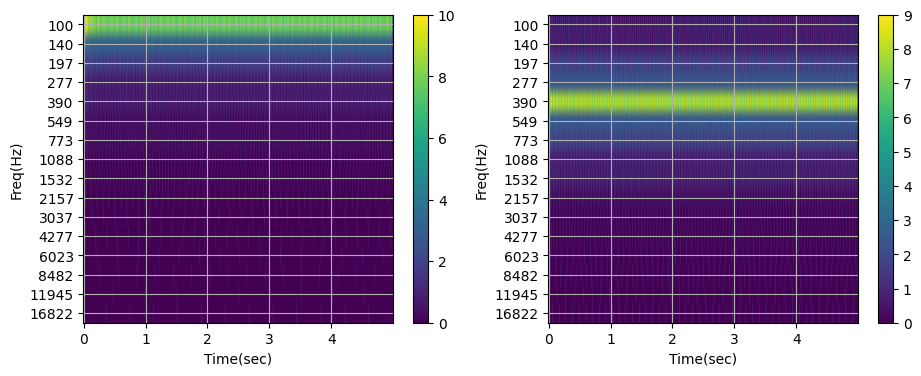

In [9]:
from rockpool.devices.xylo.syns65302.afe import ChipButterworth
import matplotlib.pyplot as plt

test_freqs = [105, 390]  #input frequencies
fs = 48000 #sampling rate 
N = 5 #input duration (seconds)
time = np.linspace(0,N,int(N*fs))

EPS = 0.00001
fb = ChipButterworth()
B_in = fb.bd_list[0].B_in + 4 # quantization range for input signal

plt.figure(figsize=(11,4))
for i,f in enumerate(test_freqs):
    sig_in = np.sin(2*np.pi*f*time)
    sig_in = sig_in/np.max(np.abs(sig_in)) * (1 + EPS) * 2**(B_in-1)     # quantize the sinal
    q_sig_in = sig_in.astype(np.int64)
    output,_, _ = afesim_external((q_sig_in,fs))
    ax = plt.subplot(1,2,i+1)
    plt.imshow(output.T, aspect='auto'); 
    plt.grid(True); plt.xlabel('Time(sec)'); plt.ylabel('Freq(Hz)')
    ax.set_xticks(range(0,500, 100)); ax.set_yticks(range(N_filters))
    ax.set_xticklabels( [int(t * np.round(dt_s, decimals=2)) for t in ax.get_xticks()])
    ax.set_yticklabels(freqs); plt.colorbar()

### Reconfiguration of filter parameters


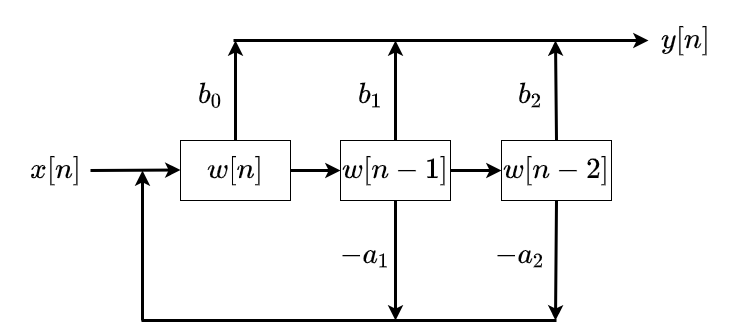

**Figure 1:** Overview of the implemented filter architecture.

In [4]:
from IPython.display import Image, display, Markdown

display(Image("figures/block_diagram.png"))
display(Markdown("**Figure 1:** Overview of the implemented filter architecture."))

As mentioned above, the design values of the filter parameters are suitable for efficient audio processing. They have been carefully chosen to ensure good coverage of the range between $100Hz$ and $17kHz$, as well as numerical stability.

Changing these parameters is **not recommended** for audio applications. However, the filter parameters can be modified by expert users in the simulator and also reconfigured in the relevant registers in hardware, for shifting the filter centers to desired values (for special non-audio use cases). In general IIR filters are sensitive to quantization and coefficient rounding and we advise users to approach filter modification with caution, especially regarding stability and numerical precision.

The main parameters to modify are $a_1$ and $a_2$ in $H(z)$. Using scipy.signal.iirpeak(), we can compute the transfer function parameters given the sampling frequency, quality factor ($Q$), and center frequency.

The following code blocks can be used to calculate the transfer function of a desired filter (i.e., the required $a_1$ and $a_2$ parameters). The example demonstrates how to modify the filters to cover a range between $300Hz$ and $20kHz$.

In [5]:
import numpy as np
f0 = 300
f15 = 20000
N_filters = 16 # number of filters
alpha = np.power(f15/f0, 1/(N_filters-1))
new_freqs = [f0]
for i in range(1,N_filters):
    new_freqs.append(int(alpha*new_freqs[-1]))
print(f'modified filter centers are: {new_freqs}')  

modified filter centers are: [300, 396, 523, 691, 914, 1209, 1599, 2115, 2798, 3702, 4898, 6480, 8573, 11342, 15006, 19854]


In [6]:
from scipy import signal
Q = 6  #Qfactor
new_params = []
for f in new_freqs:
    # Get digital filter coefficients (z-domain)
    filter_params = signal.iirpeak(f, Q, fs=fs)
    new_params.append(filter_params)

b, a =   new_params[0] #parameters of the first filter
a1 , a2 = a[1], a[2]

As in :py:class:`~.syns65302.AFESim` quantized version of filters are implemented (to match Xylo™Audio 3), $a_1$ and $a_2$ parameters need to be quantized as follows:


- $$\tilde{a}_1=[2^{B_b} 2^{B_{a,f}} a_1]~~~~~~~~~\tilde{a}_2=[2^{B_b} 2^{B_{a,f}} a_2]$$
where: 
- $B_b$ : bits needed for scaling b0
- $B_{af}$ : bits needed for encoding the fractional parts of taps

Without going into details, $B_b$ and $B_{af}$ are integer values defining precision of each parameter in the filter. They have been hard coded in :py:class:`~.syns65302.AFESim` for each of 16 filters and should not be modified. 

$\tilde{a}_1$ and $\tilde{a}_2$ can be calculated as follows and replaced in `~.syns65302.afe.ChipButterworth` module for each filter. 

In [7]:
a1_hats, a2_hats = [],[]

for i, params in enumerate(new_params):
    b, a = params
    a1 , a2 = a[1], a[2]
    B_b = fb.bd_list[i].B_b
    B_af = fb.bd_list[i].B_af
    q_scale = (2**B_b) * (2**B_af) 
    a1_hat, a2_hat = int(q_scale*a1), int(q_scale*a2)
    a1_hats.append(a1_hat)
    a2_hats.append(a2_hat)

Equavalently in HDK, $\tilde{a}_1$ and $\tilde{a}_2$ parameters can be modified by setting `bpf_a1_values` and `bpf_a2_values` on the chip configuration:

For example, in the tutorial `Using_XyloSamna_and_XyloMonitor` a chip configuration is returned after mapping a network:

`spec = mapper(model.as_graph(), weight_dtype='float', threshold_dtype='float', dash_dtype='float')`

`spec.update(q.channel_quantize(**spec))`

`xylo_conf, is_valid, msg = config_from_specification(**spec)`

To set the new $\tilde{a}_1$ and $\tilde{a}_2$ paramters, modify the returned configuration as follows:

`xylo_conf.digital_frontend.filter_bank.bpf_a1_values = a1_hats`

`xylo_conf.digital_frontend.filter_bank.bpf_a2_values = a2_hats`  

